In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import json
from tensorflow import keras
from keras import layers
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
N = 10
#T = 32
#total_range = T+200

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def radius_list(xs:np.ndarray, ys:np.ndarray):
    assert xs.ndim == 1 and ys.ndim == 1
    rad_list = [0.]
    disp_list = []
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
        disp_list.append(np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2))
    return np.array(rad_list) / np.mean(disp_list) / len(xs)

In [5]:
def shuffle(data, *args):
    shuffle_index = np.arange(len(data))
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [6]:
input_data = []
input_length = []
input_label = []

for alpha in np.arange(0.001, 2, 0.1):
    for T in range(8, 512, 4):
        total_range = T+200
        D = np.random.uniform(low=0.01, high=10.0)
        trajs_model, labels_model = models_phenom().single_state(N=N,
                                                                 L=None,
                                                                 T=total_range,
                                                                 alphas=alpha,
                                                                 Ds=[D, 0],
                                                                )
        for n_traj in range(N):
            # var_length = np.random.randint(-4, 4)
            xs = trajs_model[:, n_traj, 0][:T]
            ys = trajs_model[:, n_traj, 1][:T]
            rad_list = radius_list(xs, ys)

            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T

            input_list = np.vstack((xs, rad_list)).T
            input_data.append(input_list)
            input_label.append(alpha)
            input_length.append(T)

            input_list = np.vstack((ys, rad_list)).T
            input_data.append(input_list)
            input_label.append(alpha)
            input_length.append(T)

            for _ in range(5):
                # var_length = np.random.randint(-4, 4)
                random_start = np.random.randint(10, total_range - T)
                xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
                ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
                rad_list = radius_list(xs, ys)

                xs = xs / (np.std(xs))
                xs = np.cumsum(abs(uncumulate(xs))) / T
                ys = ys / (np.std(ys))
                ys = np.cumsum(abs(uncumulate(ys))) / T

                input_list = np.vstack((xs, rad_list)).T
                input_data.append(input_list)
                input_label.append(alpha)
                input_length.append(T)

                input_list = np.vstack((ys, rad_list)).T
                input_data.append(input_list)
                input_label.append(alpha)
                input_length.append(T)

input_data = np.array(input_data)
input_label = np.array(input_label)
input_length = np.array(input_length)

/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_8021/1398252076.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_data = np.array(input_data)


In [7]:
valid_data = []
valid_length = []
valid_label = []

for alpha in np.arange(0.001, 2, 0.1):
    for T in range(8, 512, 4):
        total_range = T+200
        D = np.random.uniform(low=0.01, high=10.0)
        trajs_model, labels_model = models_phenom().single_state(N=3,
                                                                 L=None,
                                                                 T=total_range,
                                                                 alphas=alpha,
                                                                 Ds=[D, 0],
                                                                )
        for n_traj in range(3):
            for _ in range(5):
                random_start = np.random.randint(0, total_range - T)
                xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
                ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
                rad_list = radius_list(xs, ys)

                xs = xs / (np.std(xs))
                xs = np.cumsum(abs(uncumulate(xs))) / T
                ys = ys / (np.std(ys))
                ys = np.cumsum(abs(uncumulate(ys))) / T

                input_list = np.vstack((xs, rad_list)).T
                valid_data.append(input_list)
                valid_label.append(alpha)
                valid_length.append(T)

                input_list = np.vstack((ys, rad_list)).T
                valid_data.append(input_list)
                valid_label.append(alpha)
                valid_length.append(T)

valid_data = np.array(valid_data)
valid_label = np.array(valid_label)
valid_length = np.array(valid_length)

/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_8021/399801418.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valid_data = np.array(valid_data)


In [8]:
print(len(input_data), len(input_label), len(input_length))
train_input, train_label, train_length = shuffle(input_data, input_label, input_length)
val_input, val_label, val_length = shuffle(valid_data, valid_label, valid_length)

302400 302400 302400


(120,) (120,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

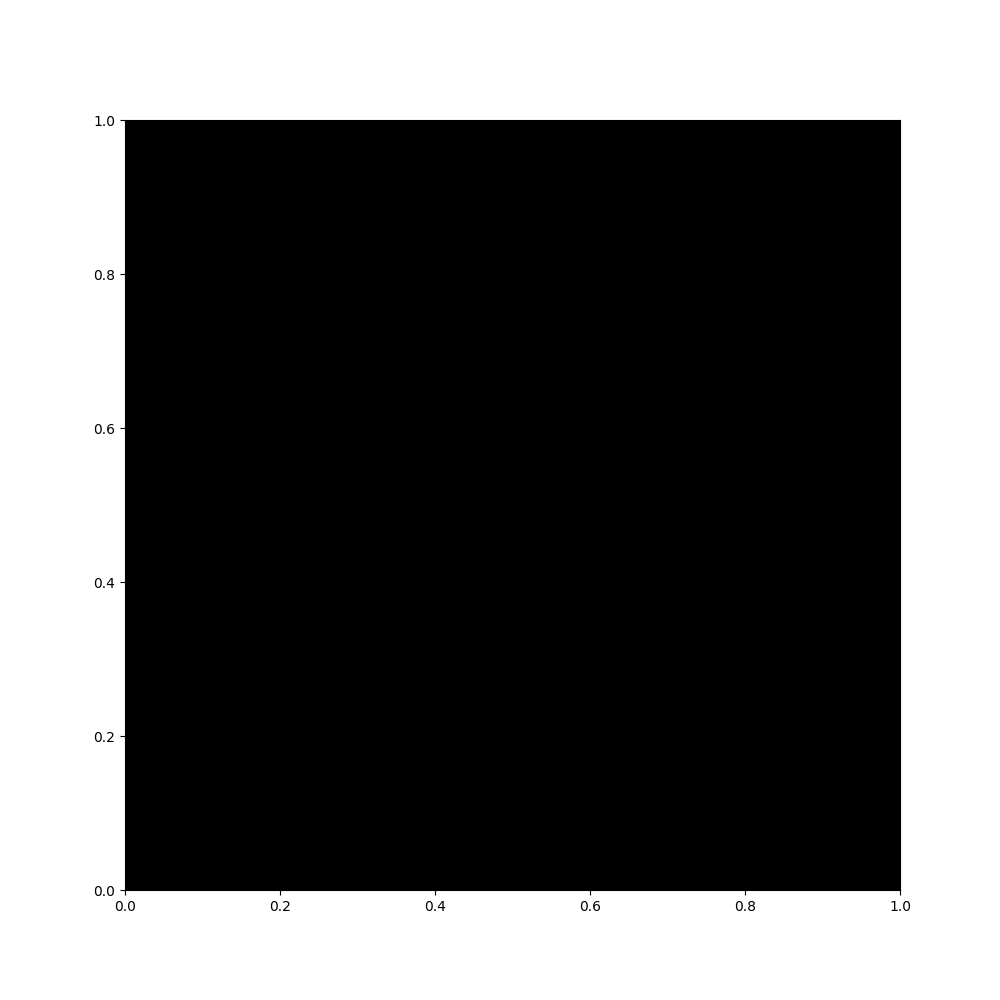

In [10]:
print(input_data.shape, input_label.shape)
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 0], color=color, alpha=0.15, zorder=-1)
ax.set_ylim([0, 1])

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 1], color=color, alpha=0.15, zorder=-1)

plt.figure()
plt.hist(train_label, bins=np.arange(0, 2, 0.01))

In [11]:
train_input = train_input.reshape(-1, T, 1, 2)
train_label = train_label.reshape(-1, 1)
val_input = val_input.reshape(-1, T, 1, 2)
val_label = val_label.reshape(-1, 1)

ValueError: cannot reshape array of size 120 into shape (14,1,2)

In [9]:
train_input = tf.ragged.constant(train_input)
train_label = tf.ragged.constant(train_label)
train_length = tf.ragged.constant(train_length)
val_input = tf.ragged.constant(val_input)
val_label = tf.ragged.constant(val_label)
val_length = tf.ragged.constant(val_length)

2024-06-01 23:25:24.598392: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-01 23:25:24.598462: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-01 23:25:24.598470: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-01 23:25:24.598720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-01 23:25:24.598749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
print(f'train_reg_shape:{train_input.shape}\n',
      f'train_label_shape:{train_label.shape}\n'
      f'val_reg_shape:{val_input.shape}\n',
      f'val_label_shape:{val_label.shape}\n'
     )

train_reg_shape:(302400, None, None)
 train_label_shape:(302400,)
val_reg_shape:(75600, None, None)
 val_label_shape:(75600,)



In [11]:
# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(None, 2) , name="reg_signals", ragged=True)

#x = layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='same')(reg_input)
#x = layers.ConvLSTM1D(filters=256, kernel_size=3, strides=1,
#                      padding='same', dropout=0.1, data_format="channels_last")(reg_input)

length_input = keras.Input(shape=(1,), name='length')
y = layers.Dense(units=16)(length_input)
y = layers.Reshape((8, 2))(y)

x = layers.Concatenate(axis=1)([reg_input, y])
x = layers.Bidirectional(layers.LSTM(256, dropout=0.1))(x)

x = layers.Dense(units=256, activation='leaky_relu')(x)
x = layers.Dense(units=128, activation='leaky_relu')(x)
reg_last_layer = layers.Dense(units=1, activation='relu')(x)

reg_model = keras.Model(
    inputs=[reg_input, length_input],
    outputs=[reg_last_layer],
    name='anomalous_regression')

In [12]:
reg_model.compile(loss=tf.keras.losses.Huber(name='huber_loss'),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=20,
                                                  mode='min',
                                                  verbose=2,
                                                  restore_best_weights=True,
                                                  start_from_epoch=3
                                                 )

In [ ]:
reg_history = reg_model.fit(x=[train_input, train_length],
                            y=train_label,
                            validation_data=([val_input, val_length], val_label),
                            batch_size=1024,
                            epochs=1500,
                            shuffle=True,
                            callbacks=[early_stopping],
                            verbose=1)
reg_model.save(f'./models/reg_model_.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_{T}.json', 'w'))

Epoch 1/1500


2024-06-01 23:26:26.731593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-01 23:26:36.935881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 226554 of 302400
2024-06-01 23:26:37.271683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


296/296 - 2455s - loss: 0.5470 - MAE: 0.9510 - val_loss: 0.5294 - val_MAE: 0.9289 - 2455s/epoch - 8s/step
Epoch 2/1500


2024-06-02 00:07:30.894877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 205454 of 302400
2024-06-02 00:07:41.203668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


# Test

In [93]:
model_check = 32
test_N = 3
test_T = 200

In [94]:
regression_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{model_check}.keras')

In [101]:
test_data = []
test_label = []
pred_label = []

for alpha in np.arange(0.001, 2, 0.001):
    if alpha % 0.5 == 0: print(f'alpha: {alpha}')
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=test_N,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(test_N):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            
            #test_data.append(np.vstack((((xs + ys) /2), rad_list)).T)
            
            test_data.append(np.vstack((xs, rad_list)).T)
            test_data.append(np.vstack((ys, rad_list)).T)     
    test_label.extend([alpha] * 25 * test_N)

test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
pred = regression_model.predict(test_data, verbose=1)
pred = pred.reshape(-1, 2).mean(axis=1)
pred_label.extend(pred)

alpha: 0.5
alpha: 1.0
alpha: 1.5
(299850, 32, 1, 2) (149925,)
9371/9371 [==============================] - 784s 84ms/step


In [105]:
pred_label = np.array(pred_label)
test_label = np.array(test_label)
print(f'MAE_valid: {np.mean(abs(pred_label - test_label))}')
grid = np.arange(-0.3, 2.3, 0.1)
H, xedges, yedges = np.histogram2d(test_label, pred_label, bins=(grid, grid), density=True)
print(test_label[:10])
print(np.round(pred_label[:10], 3))

MAE_valid: 0.13922903034652592
[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
[0.126 0.119 0.075 0.154 0.115 0.102 0.172 0.142 0.097 0.15 ]


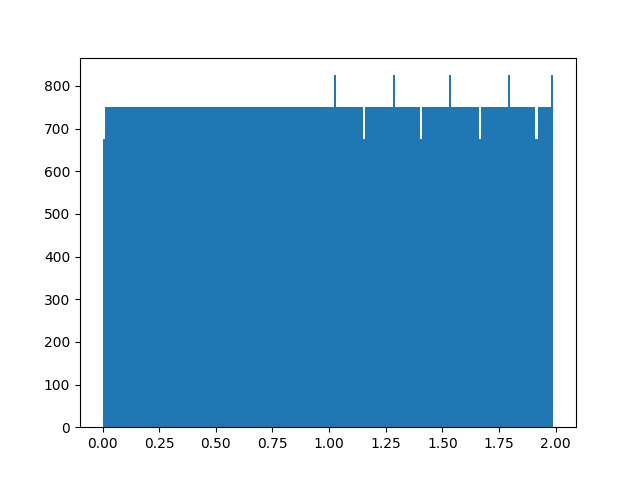

In [106]:
plt.figure()
plt.hist(test_label, bins=np.arange(0, 2, 0.01))
plt.show()

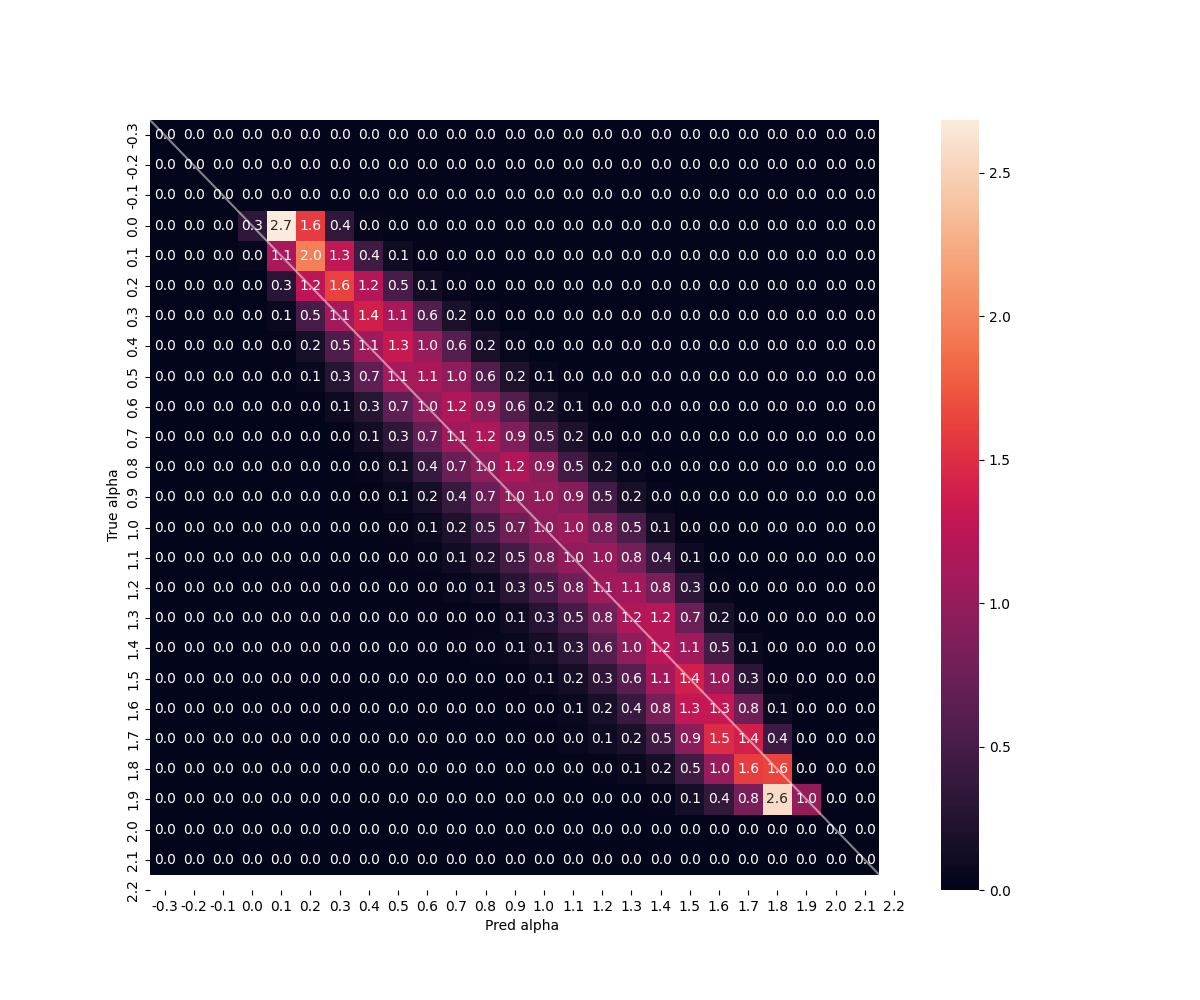

In [107]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(H, xticklabels=np.round(xedges, 1), yticklabels=np.round(yedges, 1), annot=True, fmt="3.1f")
ax.plot([0, 255],[0, 255], c='white', alpha=0.5, *ax.get_xlim())
ax.set(xlabel='Pred alpha', ylabel='True alpha')
plt.show()

In [108]:
alpha_range = np.arange(0.001, 2, 0.1)
pred_label = []
test_label = []

for alpha in alpha_range:
    print(f'alpha: {alpha}')
    test_data = []
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=100,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(100):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            
            test_data.append(np.vstack((xs, rad_list)).T)
            test_data.append(np.vstack((ys, rad_list)).T)
    
    test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
    pred = regression_model.predict(test_data, verbose=0)
    pred = pred.reshape(-1, 2).mean(axis=1)
    pred_label.append(pred)
    test_label.append([alpha] * len(pred))
    
pred_label = np.array(pred_label)
test_label = np.array(test_label)

alpha: 0.001
alpha: 0.101
alpha: 0.201
alpha: 0.30100000000000005
alpha: 0.401
alpha: 0.501
alpha: 0.6010000000000001
alpha: 0.7010000000000001
alpha: 0.801
alpha: 0.901
alpha: 1.001
alpha: 1.101
alpha: 1.201
alpha: 1.301
alpha: 1.401
alpha: 1.501
alpha: 1.601
alpha: 1.701
alpha: 1.801
alpha: 1.901


0.14139304258101043


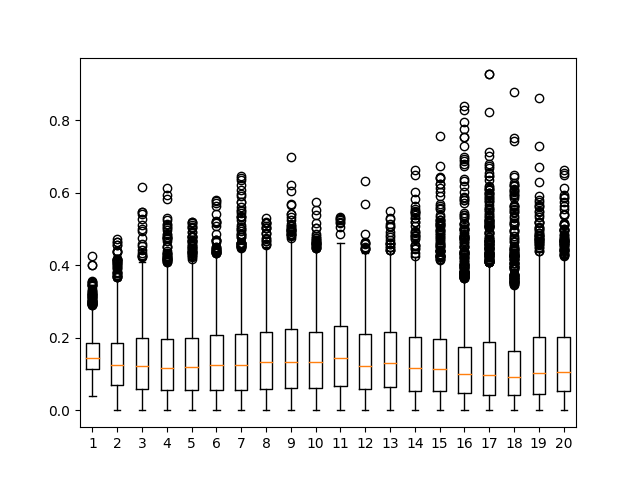

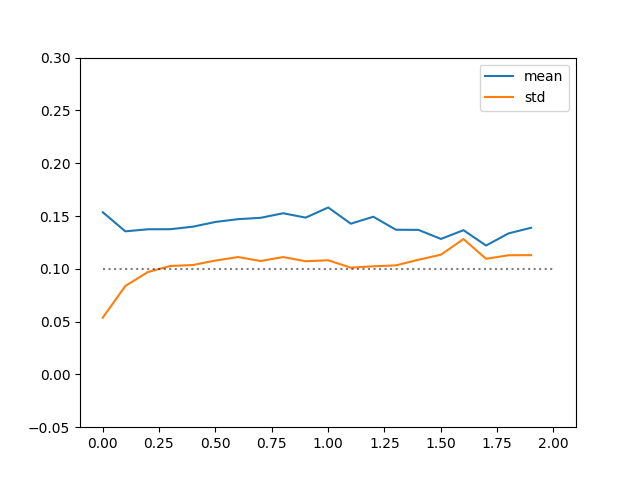

In [109]:
print(f'Total mean: {np.mean(abs(pred_label - test_label))}')
plt.figure()
plt.plot(alpha_range, np.mean(abs(pred_label - test_label), axis=1), label='mean')
plt.plot(alpha_range, np.std(abs(pred_label - test_label), axis=1), label='std')
plt.legend()
plt.hlines(y = 0.1, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.ylim([-0.05, 0.3])

plt.figure()
plt.boxplot(abs(pred_label - test_label).T)
plt.show()